<a href="https://www.kaggle.com/code/nicolastc/gan-alzheimer?scriptVersionId=94010688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-52dfc531-1eb8-c4b7-3c7b-3c1125fa5f8d)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import  image_dataset_from_directory
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, Input, 
                                     Activation, Reshape, Conv2DTranspose, 
                                     BatchNormalization, LeakyReLU, Dropout,
                                     Embedding, Concatenate, UpSampling2D)

from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import datetime
from IPython import display

z_dim = 100
batch_size = 1
DEFAULT_PATH = "./Dataset"
img_height=img_width=128
batch_size=256

# Carregando banco de imagens

In [3]:
#https://www.kaggle.com/code/theyazilimci/alzheimer-prediction-92-acc/notebook
#https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

!wget  "https://github.com/limonheiro/GAN_Classificador/raw/main/alzheimer.zip"

--2022-04-26 02:00:03--  https://github.com/limonheiro/GAN_Classificador/raw/main/alzheimer.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/limonheiro/GAN_Classificador/main/alzheimer.zip [following]
--2022-04-26 02:00:04--  https://raw.githubusercontent.com/limonheiro/GAN_Classificador/main/alzheimer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29365000 (28M) [application/zip]
Saving to: ‘alzheimer.zip’

alzheimer.zip       100%[===================>]  28.00M   146MB/s    in 0.2s    

2022-04-26 02:00:08 (146 MB/s) - ‘alzheimer.zip’ saved [29365000/29365000]



In [4]:
!unzip -q "alzheimer.zip"

In [5]:
from os import listdir
from os.path import join, isdir
class_name = np.array([f for f in listdir(DEFAULT_PATH) if isdir(join(DEFAULT_PATH, f))])
n_classes = len(class_name)

In [6]:
train_data = image_dataset_from_directory(DEFAULT_PATH,
                  validation_split=None,
                  seed=123,
                  color_mode='grayscale',
                  interpolation="nearest",
                  follow_links=False,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


# val_data = image_dataset_from_directory(DEFAULT_PATH,
#                                         validation_split=0.2,
#                                         subset="validation", 
#                                         seed=123,
#                                         color_mode="rgb",
#                                         interpolation="nearest",
#                                         follow_links=False,
#                                         image_size=(img_height, img_width),
#                                         batch_size=batch_size)

Found 6400 files belonging to 4 classes.


2022-04-26 02:00:10.698216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 02:00:10.846783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 02:00:10.847947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 02:00:10.851972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-04-26 02:00:13.240645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


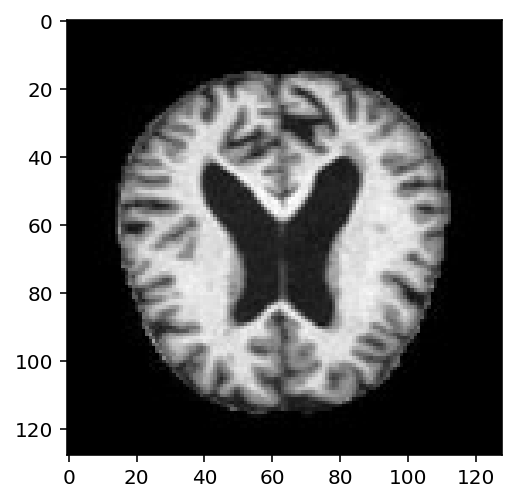

In [7]:
a, b  = next(iter(train_data.take(1)))
# a = np.expand_dims(a, axis=1)  
plt.imshow(a[0][:,:,0],cmap='gray')

# Normalização

In [8]:
def process(image,label):
    image = tf.cast(((tf.cast(image, tf.float32)/127.5) -1)  ,tf.float32)
    return image,label

train_data = train_data.map(process)

# Variaveis de entrada

In [9]:
cat_label = Input((1,))
latent_input = Input((z_dim,))

In [10]:
img_rows = 128
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)

gf = 64
df = 64

In [11]:
#U-net Generator
# define an encoder block
def conv2d(layer_in,n_filters,f_size=4,batchnorm=True,strides=2):
  # add downsampling layer
  g = Conv2D(n_filters, 
              kernel_size=f_size, 
              strides=strides, 
              padding='same')(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization(momentum=0.8)(g, training=False)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g 

# define an dencoder block
def deconv2d(layer_in,skip_in,n_filters,f_size=4,dropout=False):

  # add upsampling layer
  g= UpSampling2D(size=2)(layer_in)

  g = Conv2D(n_filters, 
            kernel_size=f_size, 
            strides=1, 
            padding='same', 
            activation='relu')(g)
  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g)
  # add batch normalization
  g = BatchNormalization(momentum=0.8)(g)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  return g

# gerador

In [12]:
def generator_label_emb(layer_input : Input, num_cat : int = n_classes, embedding_input : int = z_dim) :

  label_embedding = Embedding(num_cat, embedding_input)(layer_input)
  d1 = Dense(8*8*1)(label_embedding)
  layer_reshape = Reshape((8,8,1))(d1)
  
  return layer_reshape

In [13]:
def generator_latent_dim(layer_input : Input, latente_dim : int = z_dim):
  d1 = Dense(8*8*256)(layer_input)
  d2 = BatchNormalization()(d1)
  d3 = LeakyReLU()(d2)
  layer_reshape = Reshape((8,8,256))(d3)

  return layer_reshape

In [14]:
def Input_generator(cat_label,latent_input) -> tf.keras.models.Model :

  gle = generator_label_emb(cat_label)
  gld = generator_latent_dim(latent_input)
  input = Concatenate()([gle, gld])

  return input

In [15]:
def build_generator():
  
  input = Input_generator(cat_label,latent_input)

  #U-net Generator

  g = Conv2DTranspose(128,3,2,'same')(input)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(64,3,1,'same')(input)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(64,3,2,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(64,3,1,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(32,3,2,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(32,3,1,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(16,3,2,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(16,3,1,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)

  g = Conv2DTranspose(16,3,2,'same')(g)
  g = BatchNormalization()(g)
  g = LeakyReLU()(g)
  g = Dropout(0.3)(g)

  g = Conv2DTranspose(1,3,1,'same')(g)
  g = Activation('tanh')(g)


  return Model(inputs=[cat_label,latent_input], outputs=g)

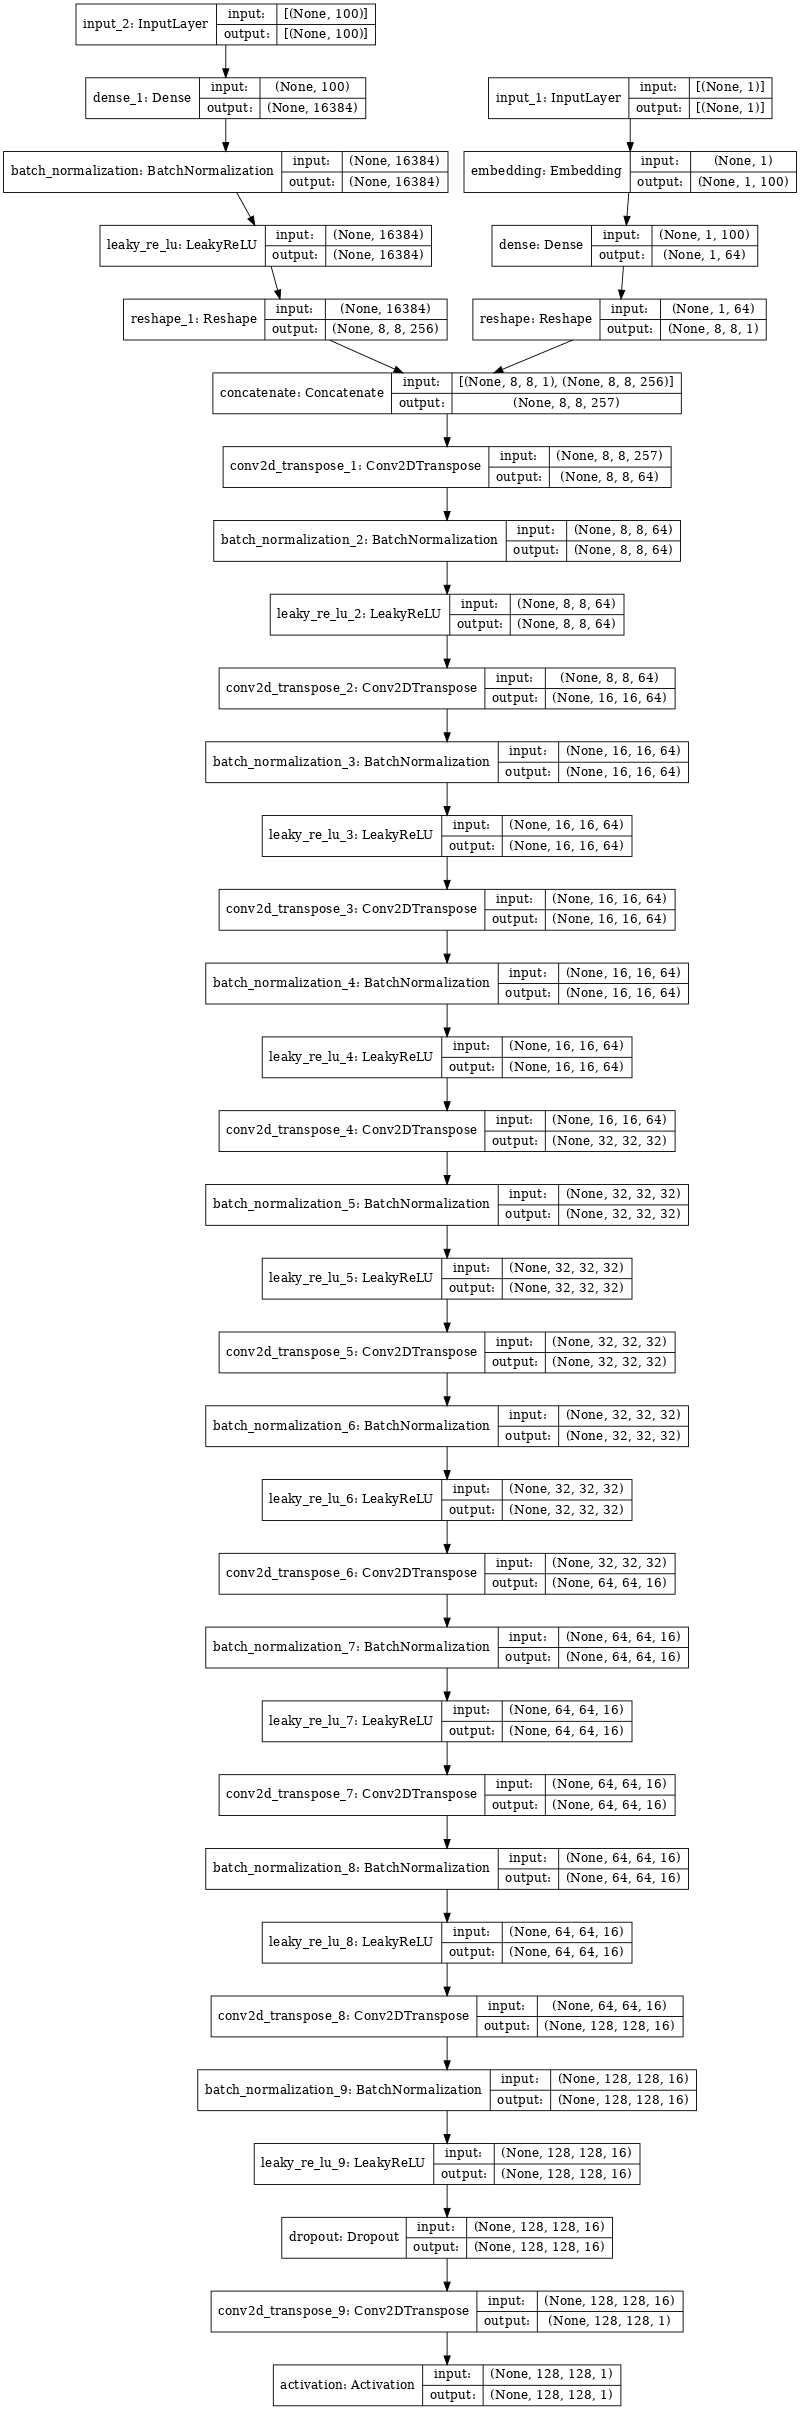

In [16]:
generator = build_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [17]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16384)        1654784     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       400         input_1[0][0]                    
______________________________________________________________________________________________

# Discriminador

In [18]:
shape_input=(128,128,1)

In [19]:
def discrimimator_label_emb(layer_input : Input, shape_input : tuple() = shape_input, num_cat : int = 10, embedding_input : int = z_dim) :

  label_embedding = Embedding(num_cat, embedding_input)(layer_input)
  d1 = Dense(shape_input[0]*shape_input[1]*shape_input[2])(label_embedding)
  layer_reshape = Reshape(shape_input)(d1)
  
  return layer_reshape

In [20]:
def discrimimator_input(shape_input : tuple() = shape_input, latente_dim : int = z_dim):
  layer_input = Input(shape_input)
  return layer_input

In [21]:
def discriminator():

  layer_label_emb = discrimimator_label_emb(cat_label)
  layer_input = discrimimator_input()
  concate = Concatenate()([layer_label_emb,layer_input])

  d = Conv2D(64,3,2,'same')(concate)
  d = LeakyReLU()(d)
  d = Dropout(0.3)(d)

  d = Conv2D(128,3,2,'same')(d)
  d = LeakyReLU()(d)
  d = Dropout(0.3)(d)

  d = Conv2D(64,3,2,'same')(d)
  d = LeakyReLU()(d)
  d = Dropout(0.3)(d)

  d = Conv2D(32,3,2,'same')(d)
  d = LeakyReLU()(d)
  d = Dropout(0.3)(d)

  d = Conv2D(8,3,2,'same')(d)
  d = LeakyReLU()(d)
  d = Dropout(0.3)(d)

  d = Flatten()(d)
  d = Activation('sigmoid')(d)
  d = Dense(1)(d)


  model = Model(inputs=[layer_input,cat_label], outputs=d, name="discriminator")
  return model

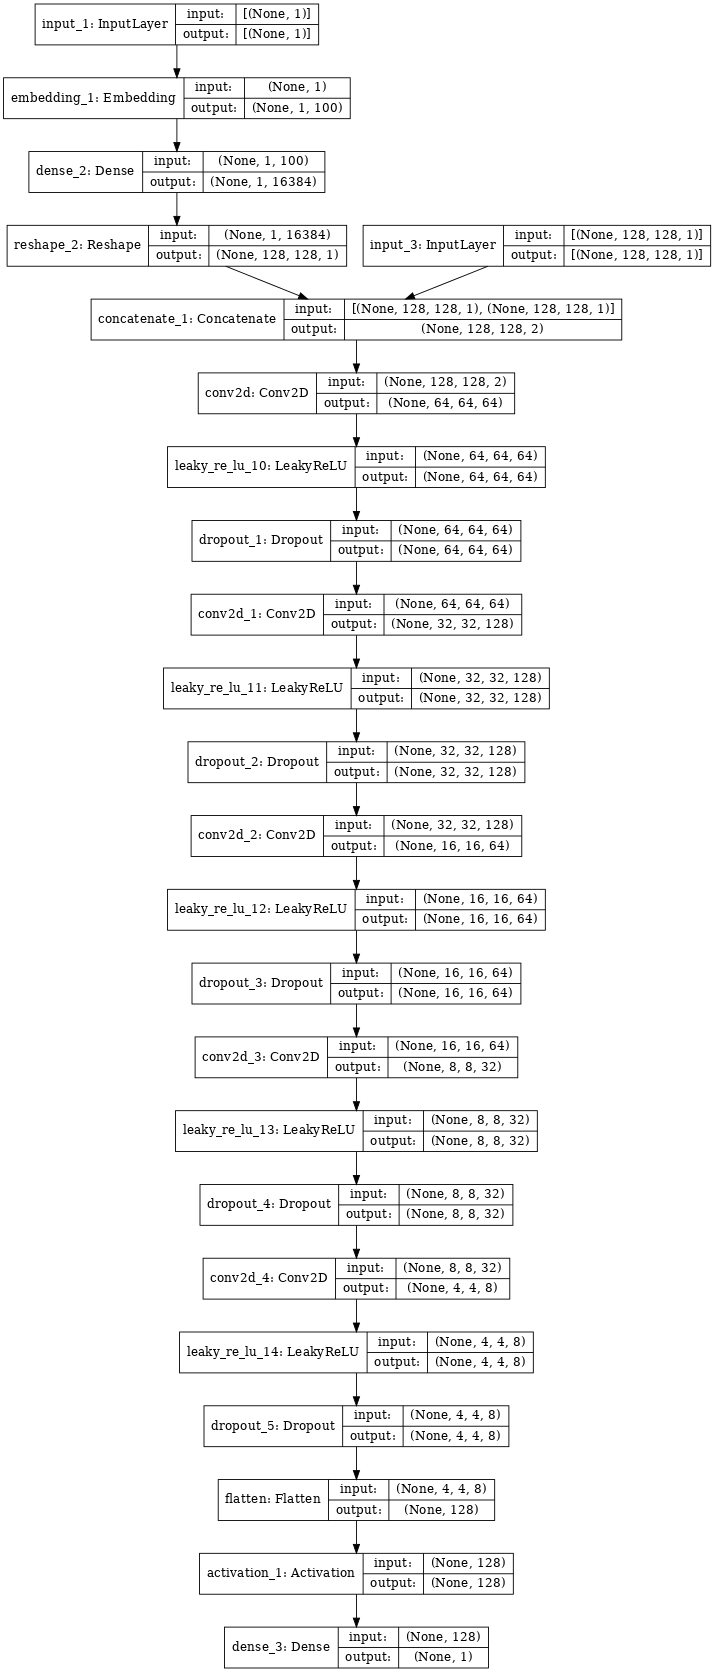

In [22]:
discriminator = discriminator()
tf.keras.utils.plot_model(discriminator,to_file='discriminator.png', show_shapes=True, dpi=64)

In [23]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 16384)     1654784     embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 128, 128, 1)  0           dense_2[0][0]                    
______________________________________________________________________________________

In [24]:
generator_optimizer = tf.optimizers.Adam(0.0001)
discriminator_optimizer = tf.optimizers.Adam(0.0001)

## Checkpoint

In [25]:
default_patch = "./"

In [26]:
checkpoint_dir = default_patch + '/check/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
log_dir = default_patch + "/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/')

In [28]:
rows=n_classes
cols=1
noises = np.random.normal(0, 1, (rows * cols, z_dim))
num_labels = np.arange(0, rows).reshape(-1, 1)

In [29]:
def sample_images(model, rows=2, cols=2):
  prediction = model([num_labels,noises], training=False)

  plot, axs = plt.subplots(rows, cols,figsize=(10, 5))  
  
  gen_imgs = [p for p in prediction]
  pos_img = 0
  for r in range(rows):
    for c in range(cols):
      axs[r,c].axis('off')
      axs[r,c].set_title(f'{class_name[pos_img]}')
      axs[r,c].imshow(gen_imgs[pos_img][:,:,0] * 0.5 + 0.5, cmap='gray')
      pos_img += 1
  plt.show()

2022-04-26 02:00:21.637222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


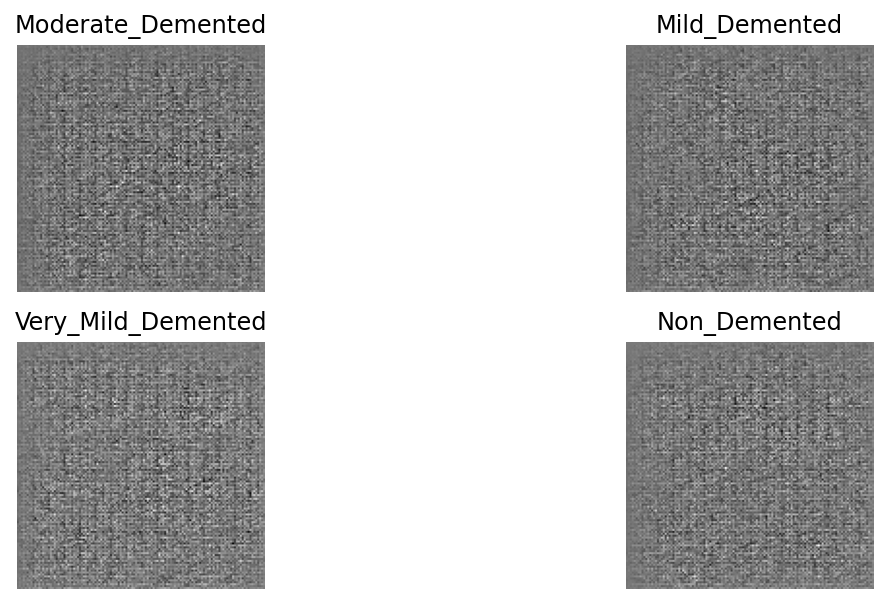

In [30]:
sample_images(model=generator)

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def discrimantor_loss(disc_fake, disc_real, step, add_summary=True):
  loss_disc_real = loss_object(tf.ones_like(disc_real),disc_real)
  
  loss_disc_fake = loss_object(tf.zeros_like(disc_fake),disc_fake)
  
  loss_disc = (loss_disc_real + loss_disc_fake)

  if add_summary:
    with summary_writer.as_default():
      tf.summary.scalar('loss_disc_real', loss_disc_real, step = step // 1000)
      tf.summary.scalar('loss_disc_fake', loss_disc_fake, step = step // 1000)
      tf.summary.scalar('loss_disc', loss_disc, step = step // 1000)

  return loss_disc, loss_disc_real, loss_disc_fake

In [33]:
def generator_loss(gen_out, step):

  loss_gen_out = loss_object(tf.ones_like(gen_out),gen_out)

  with summary_writer.as_default():
    tf.summary.scalar('loss_gen_out', loss_gen_out, step = step // 1000)

  return loss_gen_out

## Train

In [34]:
%reload_ext tensorboard

In [35]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
@tf.function
def train_step(input_image, input_label, generator, discriminator, step):
  z_noise  = np.random.normal(0,1,(input_label.shape[0], z_dim))

  assert z_noise.shape == (input_label.shape[0], z_dim)


  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_real, tf.GradientTape() as disc_tape_fake:
    #Train Generator
    gen_out = generator([input_label,z_noise], training=True)

    #Train Discriminator
    disc_fake = discriminator([gen_out, input_label], training=True)
    disc_real = discriminator([input_image, input_label], training=True)

    #Loss Discriminator
    loss_disc, loss_disc_real, loss_disc_fake = discrimantor_loss(disc_fake, disc_real, step)

    #Loss Generator
    loss_gen_out = generator_loss(disc_fake, step)

    
  #Generator Gradiente
  generator_gradients = gen_tape.gradient(loss_gen_out,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

  #Discriminator Gradiente to real imagens
  discriminator_gradients = disc_tape_real.gradient(loss_disc_real,discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

  #Discriminator Gradiente to fake imagens
  discriminator_gradients = disc_tape_fake.gradient(loss_disc_fake,discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
  

In [37]:
def fit(interations):
  start = datetime.datetime.now()
  start_1k = datetime.datetime.now()
  for (step, input_image) in train_data.repeat().take(interations).enumerate():
    train_step(input_image[0], input_image[1], generator, discriminator, step)

    if( (step+1) % 1000 == 0):
      checkpoint.save(file_prefix=checkpoint_prefix)
      display.clear_output(wait=True)
      print(f'Time per 1k steps:{datetime.datetime.now()-start_1k}')
      start_1k = datetime.datetime.now()
      print(f'step: {(step+1)//1000}k')
      sample_images(generator)
      print(f'Total time:{datetime.datetime.now()-start}')

Time per 1k steps:0:05:19.016936
step: 50k


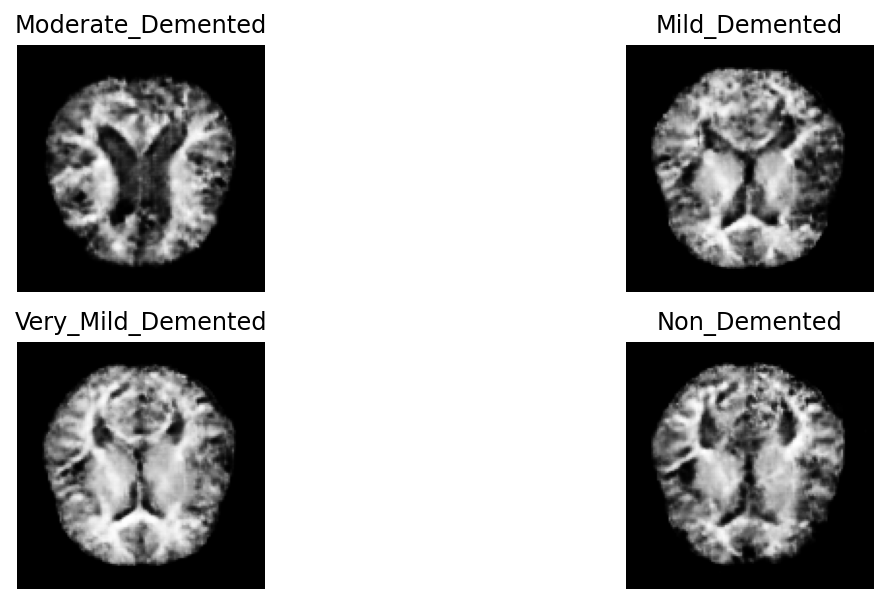

Total time:4:25:47.996711


In [38]:
fit(50000)

In [39]:
def test_train(model, rows=1, cols=5):
  
  for n in range(4):

    labels = np.ones((5,1)) * n
    z_dim_lat = np.random.normal(0, 1, (1 * 5, z_dim))

    prediction = model([labels, z_dim_lat], training=False)

    plt.subplots(1, 5,figsize=(10, 5))
    
    
    gen_imgs = [p for p in prediction]
    pos_img = 0
    for c in range(cols):
      plt.subplot(1,5, c+1)
      plt.axis('off')
      plt.title(f'{class_name[int(labels[pos_img])]}')
      plt.imshow(gen_imgs[pos_img][:,:,0] * 0.5 + 0.5, cmap='gray')
      pos_img += 1
  plt.show()

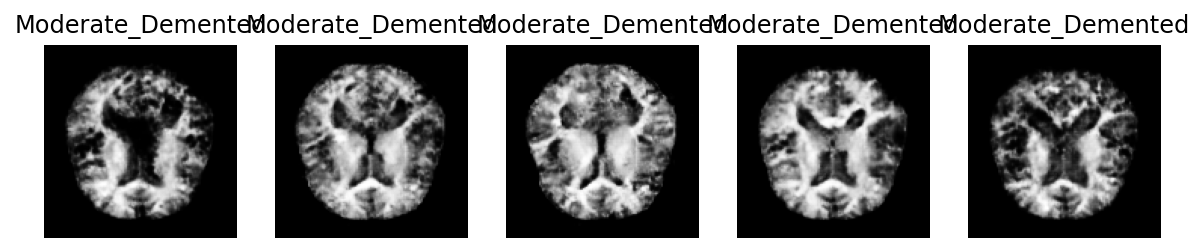

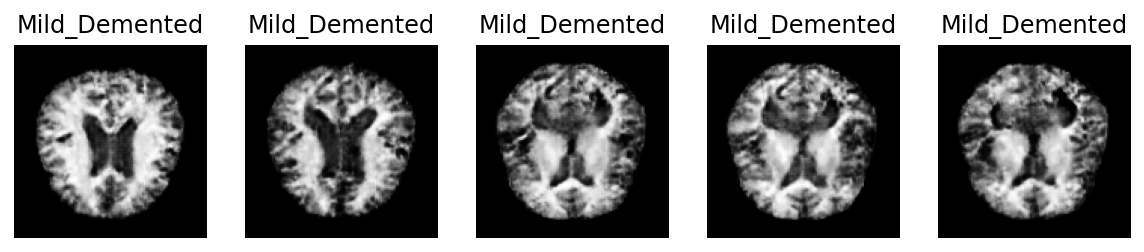

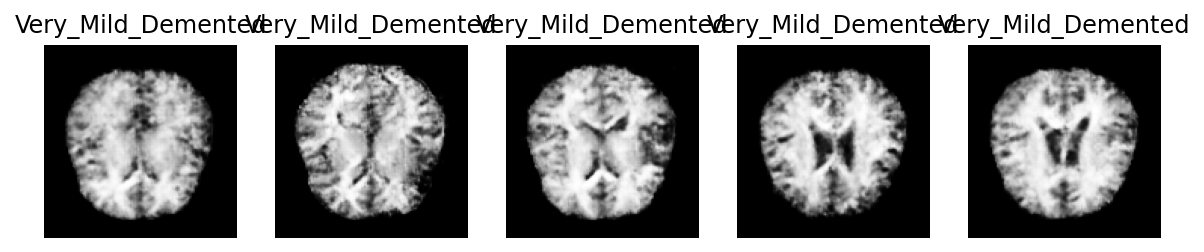

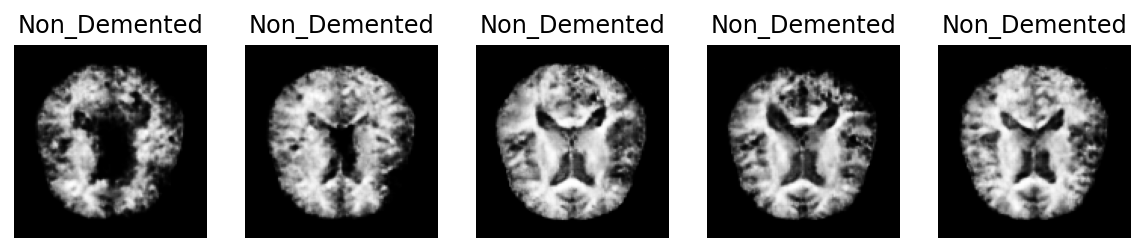

In [40]:
test_train(generator)

In [41]:
class_name[1]

'Mild_Demented'

In [42]:
print(1)

1


In [43]:
!ls ./check

checkpoint		     ckpt-32.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-32.index
ckpt-1.index		     ckpt-33.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-33.index
ckpt-10.index		     ckpt-34.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-34.index
ckpt-11.index		     ckpt-35.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-35.index
ckpt-12.index		     ckpt-36.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-36.index
ckpt-13.index		     ckpt-37.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-37.index
ckpt-14.index		     ckpt-38.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-38.index
ckpt-15.index		     ckpt-39.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-39.index
ckpt-16.index		     ckpt-4.data-00000-of-00001
ckpt-17.data-00000-of-00001  ckpt-4.index
ckpt-17.index		     ckpt-40.data-00000-of-00001
ckpt-18.data-00000-of-00001  ckpt-40.index
ckpt-18.index		     ckpt-41.data-00000-of-00001
ckpt-19.data-00000-of-00001  ckpt-41.index
ckpt-

In [44]:
!zip -r checkpoint ./check

  adding: check/ (stored 0%)
  adding: check/ckpt-45.index (deflated 77%)
  adding: check/ckpt-4.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-50.index (deflated 77%)
  adding: check/ckpt-35.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-40.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-7.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-26.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-10.index (deflated 77%)
  adding: check/ckpt-27.index (deflated 77%)
  adding: check/ckpt-44.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-10.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-49.index (deflated 77%)
  adding: check/ckpt-33.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-7.index (deflated 77%)
  adding: check/ckpt-24.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-37.data-00000-of-00001 (deflated 8%)
  adding: check/ckpt-20.index (deflated 77%)
  adding: check/ckpt-16.index (deflated 77%)
  adding: check/ckpt-50.data-00000

In [45]:
!pwd

/kaggle/working
